# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:

from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-5,2e-7,3e-7,2e-6,5e-8,1e-2,1e-3,1e-1,]
regularization_strengths = [3e5,4e5,1e7,0.05,0.025,0.015,0.020]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
for rate in learning_rates:
    for strength in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=strength,
                      num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy= (np.mean(y_train == y_train_pred))
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy= (np.mean(y_val == y_val_pred))
        if (val_accuracy>best_val):
            best_val= val_accuracy
            best_svm= svm
            
        results[ (rate,strength)]= (train_accuracy,val_accuracy)
         
    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 444.271997
iteration 100 / 2000: loss 27087369206869986495013085118742276212411676869854516595942497903330712898311252897255694407259206946367772134551467973894034515486993215913984.000000
iteration 200 / 2000: loss 1685651124114207000207768558081365468807553675654749475438607511860649052122026157035780060121433172134598990851942423828508813263645064933083001298744059558376909187974147666487304220977908973150064255784354344952741664534286822397253606679399867679879042293820276219113990124470272.000000


/Users/prateekagarwal/Desktop/682/assignment1/cs682/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss=loss/X.shape[0]+ reg* np.sum(np.square(W))
/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/prateekagarwal/Desktop/682/assignment1/cs682/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in square
  loss=loss/X.shape[0]+ reg* np.sum(np.square(W))
/Users/prateekagarwal/Desktop/682/assignment1/cs682/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  dW= np.divide(X.T @ gradloss + X.T@ gradloss2,num_train) + 2*reg*W
/Users/prateekagarwal/Desktop/682/assignment1/cs682/classifiers/linear_svm.py:83: RuntimeWarning: invalid value encountered in matmul
  loss= X @ W


iteration 300 / 2000: loss inf
iteration 400 / 2000: loss inf
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 642.667170
iteration 100 / 2000: loss 6629341992995294629885470522561687596363406844435299295814827341270896242046440442201806263204486167584722601784018621071693137007865668253932667137131773921913527531995136.000000
iteration 200 / 2000: loss inf
iteration 300 / 2000: loss inf
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
ite

/Users/prateekagarwal/Desktop/682/assignment1/cs682/classifiers/linear_svm.py:86: RuntimeWarning: invalid value encountered in subtract
  loss=loss- loss[np.arange(loss.shape[0]),y][:,None]


iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 8.994071
iteration 100 / 2000: loss 8.950596
iteration 200 / 2000: loss 8.850224
iteration 300 / 2000: loss 8.800148
iteration 400 / 2000: loss 8.739664
iteration 500 / 2000: loss 8.688261
iteration 600 / 2000: loss 8.584454
iteration 700 / 2000: loss 8.590669
iteration 800 / 2000: loss 8.467217
iteration 900 / 2000: loss 8.408156
iteration 1000 / 2000: loss 8.300099
iteration 1100 / 2000: loss 8.246096
iteration 1200 / 2000: loss 8.137995
iteration 1300 / 2000: loss 8.004752
iteration 1400 / 20

iteration 1800 / 2000: loss 8.975608
iteration 1900 / 2000: loss 8.977601
iteration 0 / 2000: loss 9.009192
iteration 100 / 2000: loss 9.001049
iteration 200 / 2000: loss 8.997388
iteration 300 / 2000: loss 8.997216
iteration 400 / 2000: loss 8.989879
iteration 500 / 2000: loss 9.004431
iteration 600 / 2000: loss 8.975560
iteration 700 / 2000: loss 8.990892
iteration 800 / 2000: loss 8.988773
iteration 900 / 2000: loss 8.979243
iteration 1000 / 2000: loss 8.993973
iteration 1100 / 2000: loss 8.969153
iteration 1200 / 2000: loss 8.968063
iteration 1300 / 2000: loss 8.993092
iteration 1400 / 2000: loss 8.978347
iteration 1500 / 2000: loss 8.997296
iteration 1600 / 2000: loss 8.960539
iteration 1700 / 2000: loss 8.976736
iteration 1800 / 2000: loss 8.976656
iteration 1900 / 2000: loss 8.964992
iteration 0 / 2000: loss 456.854659
iteration 100 / 2000: loss 8.999946
iteration 200 / 2000: loss 8.999947
iteration 300 / 2000: loss 8.999939
iteration 400 / 2000: loss 8.999946
iteration 500 / 20

iteration 0 / 2000: loss 8.990395
iteration 100 / 2000: loss 8.983801
iteration 200 / 2000: loss 8.950505
iteration 300 / 2000: loss 8.937595
iteration 400 / 2000: loss 8.938332
iteration 500 / 2000: loss 8.912745
iteration 600 / 2000: loss 8.900822
iteration 700 / 2000: loss 8.873346
iteration 800 / 2000: loss 8.891615
iteration 900 / 2000: loss 8.861298
iteration 1000 / 2000: loss 8.844431
iteration 1100 / 2000: loss 8.828728
iteration 1200 / 2000: loss 8.833827
iteration 1300 / 2000: loss 8.804534
iteration 1400 / 2000: loss 8.792188
iteration 1500 / 2000: loss 8.779732
iteration 1600 / 2000: loss 8.738994
iteration 1700 / 2000: loss 8.741431
iteration 1800 / 2000: loss 8.679515
iteration 1900 / 2000: loss 8.720979
iteration 0 / 2000: loss 8.990626
iteration 100 / 2000: loss 8.995168
iteration 200 / 2000: loss 8.961044
iteration 300 / 2000: loss 8.969874
iteration 400 / 2000: loss 8.944427
iteration 500 / 2000: loss 8.944485
iteration 600 / 2000: loss 8.908497
iteration 700 / 2000: 

iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan
iteration 0 / 2000: loss 617.608488
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 

iteration 1300 / 2000: loss 3.037409
iteration 1400 / 2000: loss 3.366211
iteration 1500 / 2000: loss 3.247676
iteration 1600 / 2000: loss 3.399088
iteration 1700 / 2000: loss 3.429830
iteration 1800 / 2000: loss 3.092024
iteration 1900 / 2000: loss 3.183121
iteration 0 / 2000: loss 8.999990
iteration 100 / 2000: loss 5.016973
iteration 200 / 2000: loss 4.381081
iteration 300 / 2000: loss 3.647492
iteration 400 / 2000: loss 3.849698
iteration 500 / 2000: loss 3.479283
iteration 600 / 2000: loss 3.748381
iteration 700 / 2000: loss 3.450554
iteration 800 / 2000: loss 3.542775
iteration 900 / 2000: loss 3.090358
iteration 1000 / 2000: loss 3.068741
iteration 1100 / 2000: loss 3.184702
iteration 1200 / 2000: loss 3.248110
iteration 1300 / 2000: loss 3.662218
iteration 1400 / 2000: loss 3.398544
iteration 1500 / 2000: loss 3.191735
iteration 1600 / 2000: loss 3.065862
iteration 1700 / 2000: loss 3.422291
iteration 1800 / 2000: loss 3.117964
iteration 1900 / 2000: loss 3.480449
iteration 0 /

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)


0.488


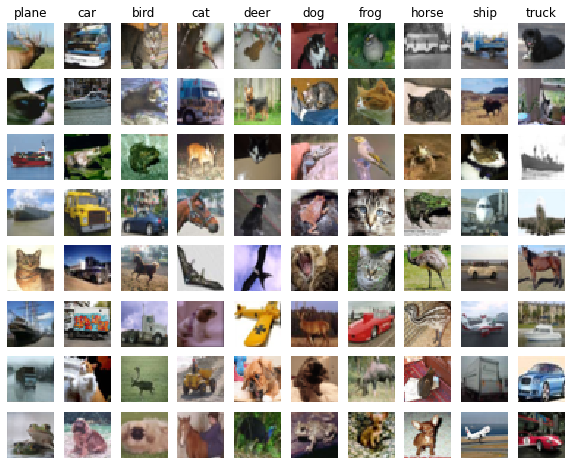

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
We can see classifications based on background pixel similarities like in the plane category, we can see that the moose and cat and boat are in the same category due to their blue background which makes sense. We can see that there are certain cats with green backgrounds in the frog category which also makes sense as they are grouped based on their similar background. Conversely, a planes is classified a ship because of a similar blue background. 


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
from cs682.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best_val=0

learning_rate_decay=0.95
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# 125, 1700, 200, 0.001, 0.5

hidden_size = [500]
num_classes = 10
num_it= [10000]
batch_size=[200]
# 0.75
learning_rate= [0.5]
regularization= [0.001]


# lr 1.000000e-02 reg 2.000000e-02 train accuracy: 0.508490 val accuracy: 0.504000

for hs in hidden_size:
    for nit in num_it:
        for bs in batch_size:
            for lr in learning_rate:
                for re in regularization:
                    print("1")
                    net = TwoLayerNet(input_dim, hs, num_classes)
                    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,lr,learning_rate_decay,re,nit,bs,verbose=True)      
                    val_acc = (net.predict(X_val_feats) == y_val).mean()
                    best_net= net
                    print(hs,nit,bs,lr,re,val_acc)
                    
                    
                    
#                     results[(hs,nit,bs,lr,re)]= val_acc
#                     if (val_acc>best_val):
#                         best_val= val_acc
#                         best_net= net
                    
                        

                        
                        
# print(results)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1
iteration 0 / 10000: loss 2.302586
iteration 100 / 10000: loss 1.565228
iteration 200 / 10000: loss 1.342673
iteration 300 / 10000: loss 1.274297
iteration 400 / 10000: loss 1.537018
iteration 500 / 10000: loss 1.370274
iteration 600 / 10000: loss 1.344846
iteration 700 / 10000: loss 1.223139
iteration 800 / 10000: loss 1.298420
iteration 900 / 10000: loss 1.366179
iteration 1000 / 10000: loss 1.204315
iteration 1100 / 10000: loss 1.337439
iteration 1200 / 10000: loss 1.177552
iteration 1300 / 10000: loss 1.267438
iteration 1400 / 10000: loss 1.294760
iteration 1500 / 10000: loss 1.186429
iteration 1600 / 10000: loss 1.189098
iteration 1700 / 10000: loss 1.172402
iteration 1800 / 10000: loss 1.086359
iteration 1900 / 10000: loss 1.156961
iteration 2000 / 10000: loss 1.126775
iteration 2100 / 10000: loss 1.177620
iteration 2200 / 10000: loss 1.061212
iteration 2300 / 10000: loss 1.016636
iteration 2400 / 10000: loss 1.151287
iteration 2500 / 10000: loss 1.048933
iteration 2600 / 10000

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.597
